# Metrics

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pyperclip
import math
from utils.logging_metrics import MetricsLogger
import re
from datetime import datetime
import warnings
import numpy as np

RESULT_FOLDER = "metrics/final_results/"
METRICS_LOGGER_FOLDER = "metrics/logged_metrics/"

SET_TYPES = ["test", "train"]
EXPERIMENTS = ["interpolation", "interpolation_coords", "extrapolation"]#, "OLD"] TODO
VALID_EXPERIMENTS = EXPERIMENTS + ["OLD"]

#TODO fix this list
USELESS_METRICS = ["explained_variance_score",
                   "mean_absolute_percentage_error",
                   "median_absolute_error", 
                   "timestamp"]
USELESS_MODELS = ["autoencoder"]

METRIC_TO_ABBREVIATION = {
    "r2_score": "r2",
    "explained_variance_score": "EVS",
    "mean_squared_error": "MSE",
    "mean_absolute_error": "MAE",
    "median_absolute_error": "MedAE",
    "mean_absolute_percentage_error": "MAPE",
    "peak_signal_noise_ratio": "PSNR"
}

COLUMNS_TO_BE_MAXIMIZED = ['r2_score', 'explained_variance_score', 'peak_signal_noise_ratio']
COLUMNS_TO_BE_MAXIMIZED += [abb for m, abb in METRIC_TO_ABBREVIATION.items() if m in COLUMNS_TO_BE_MAXIMIZED]
COLUMNS_TO_BE_MINIMIZED = ['prediction_time', 'mean_squared_error', 'mean_absolute_error',
                           'median_absolute_error', 'mean_absolute_percentage_error', 'Prediction Time']
COLUMNS_TO_BE_MINIMIZED += [abb for m, abb in METRIC_TO_ABBREVIATION.items() if m in COLUMNS_TO_BE_MINIMIZED]

pd.set_option('display.max_colwidth', None)

### Training time

In [13]:
def __find_most_recent_metrics_log(model_name: str) -> str | None:
    # code from MetricsLogger conventions
    model_name = re.sub(r'[^a-zA-Z0-9 -_]', '', model_name)\
                    .replace(" ", "-")\
                    .split("_discr_factors")[0]
    matching_files = [file for file in os.listdir(METRICS_LOGGER_FOLDER) if file.startswith(model_name)]
    
    if not matching_files:
        #warnings.warn(f"No files found in {METRICS_LOGGER_FOLDER} with the prefix {model_name}")
        return None
    
    # Sort the files based on their timestamps (assuming the timestamp is at the end of the filename)
    sorted_files = sorted(matching_files,
                          key=lambda file: datetime.strptime(file[-23:-4], "%d-%m-%Y_%H-%M-%S"),
                          reverse=True)
    
    most_recent_metrics_log = os.path.join(METRICS_LOGGER_FOLDER, sorted_files[0])
    return most_recent_metrics_log

def compute_training_time(model_name: str) -> float:
    most_recent_log_file = __find_most_recent_metrics_log(model_name)
    if most_recent_log_file is None:
        return np.nan
    metrics_logger = MetricsLogger.from_csv(most_recent_log_file)
    training_time = metrics_logger.get_training_time('Validation loss')
    if int(training_time) == 0:
        return np.nan
    return training_time

compute_training_time("conv_autoencoders_channels2-4-8-8_kernels3-4-5-5_strides2-2-2-2_paddings1-1-1-1_lin-layers4096-2048-1024-512-256-128-64-32-16-8_consider_ws")

1572

### Loading metrics

In [14]:
def load_metrics(set_type: str, experiment: str,
                 only_model_name: bool = True,
                 columns_to_remove: list = USELESS_METRICS) -> pd.DataFrame:
    __check_arguments(set_type, experiment)
    filepath = __get_filepath(set_type, experiment)
    metrics = pd.read_csv(filepath)
    # remove uninteresting records
    for model_name in USELESS_MODELS:
        metrics = metrics[~metrics['model_description'].str.contains(model_name)]
        #metrics = metrics[~metrics['model_description'].str.contains('consider_ws')] #TODO ?

    if only_model_name:
        metrics['model_description'] = metrics['model_description']\
            .str.split("_").str[:2].str.join(" ")\
            .apply(__first_capital)
        metrics.rename(columns={"model_description": "model_name"}, inplace=True)
    
    if columns_to_remove:
        metrics.drop(columns_to_remove, axis=1, inplace=True)

    metrics.rename(columns=__rename_column, inplace=True)
    
    return metrics

def __check_arguments(set_type: str | None = None,
                      experiment: str | None = None,
                      metric: str | None = None) -> None:
    if set_type and set_type not in SET_TYPES:
        raise ValueError("set_type should be 'train' or 'test'")
    if experiment and experiment not in VALID_EXPERIMENTS:
        raise ValueError("experiment argument not valid")
    if metric and metric not in METRIC_TO_ABBREVIATION.values():
        raise ValueError(f"Not a valid (abbreviated) metric, choose among: {METRIC_TO_ABBREVIATION.values()}")

def __get_filepath(set_type: str, experiment: str) -> str:
    __check_arguments(set_type, experiment)
    filename = "_".join([set_type + "set", "results", experiment]) + ".csv"
    return os.path.join(RESULT_FOLDER, filename)

def __rename_column(column_name: str) -> str:
    if column_name in METRIC_TO_ABBREVIATION.keys():
        return METRIC_TO_ABBREVIATION[column_name]
    return column_name.replace("_", " ").title()

def __first_capital(value: str) -> str:
    return value[0].upper() + value[1:]

def compare_metrics(set_type1: str, experiment1: str, set_type2: str, experiment2: str) -> pd.DataFrame:
    if set_type1 == set_type2 and experiment1 == experiment2:
        raise ValueError("types and experiments are the same -> impossible to merge")
    
    metrics1 = load_metrics(set_type1, experiment1, only_model_name=True)
    metrics2 = load_metrics(set_type2, experiment2, only_model_name=True)

    if set_type1 != set_type2 and experiment1 == experiment2:
        suffix1 = f" ({set_type1})"
        suffix2 = f" ({set_type2})"
    elif set_type1 == set_type2 and experiment1 != experiment2:
        suffix1 = f" ({experiment1})"
        suffix2 = f" ({experiment2})"
    elif set_type1 != set_type2 and experiment1 != experiment2:
        suffix1 = f" ({set_type1}, {experiment1})"
        suffix2 = f" ({set_type2}, {experiment2})"
    
    return merge_metrics(metrics1, metrics2, suffix1, suffix2)

def merge_metrics(metrics1: pd.DataFrame, metrics2: pd.DataFrame, suffix1: str, suffix2: str) -> pd.DataFrame:
    return pd.merge(metrics1, metrics2, on='Model Name', suffixes=(suffix1, suffix2))\
        .set_index("Model Name")\
        .sort_index(axis=1)\
        .reset_index()

def load_all_metrics(set_type: str, experiments: list[str] = EXPERIMENTS,
                     columns_to_remove: list = USELESS_METRICS,
                     infer_training_time_attempt: bool = False) -> pd.DataFrame:
    #TODO update method including with more set types?
    # the problem is that the information about the type is not contained
    # anywhere but in the name of the file
    all_metrics = list()
    for experiment in experiments:
        metrics = load_metrics(set_type, experiment,
                                only_model_name=False,
                                columns_to_remove=columns_to_remove)
        all_metrics.append(metrics)
    
    all_metrics = pd.concat(all_metrics).reset_index(drop=True)
    if infer_training_time_attempt: #TODO feature in progress
        all_metrics["Training Time (s)"] = all_metrics["Model Description"].apply(compute_training_time)
    return all_metrics

def load_metrics_by_model(model_name: str, set_type: str, experiments: list[str] = EXPERIMENTS,
                          columns_to_remove: list = USELESS_METRICS,
                          infer_training_time_attempt: bool = False):
    model_name = model_name.lower().replace(" ", "_")
    
    all_metrics = load_all_metrics(set_type,
                                   experiments=experiments,
                                   columns_to_remove=columns_to_remove,
                                   infer_training_time_attempt=infer_training_time_attempt)
    return all_metrics[all_metrics["Model Description"].str.lower().str.contains(model_name)]

def best_result_per_model(by_metric: str, set_type: str):
    __check_arguments(set_type=set_type, metric=by_metric)
    all_metrics = load_all_metrics(set_type)
    # add a colum to group the models on
    all_metrics["Model Name"] = all_metrics['Model Description']\
        .str.split("_").str[:2].str.join(" ")\
        .apply(__first_capital)
    # group
    return all_metrics.loc[all_metrics.groupby("Model Name")[by_metric].idxmax()]\
        .set_index("Model Name").reset_index()

### Other comparisons

In [15]:
def extract_parameter(metrics: pd.DataFrame,
                      parameter_name: str,
                      parameter_type: type,
                      regex: str) -> pd.DataFrame:
    # example of regex: r"approxGP_(\d+)fourier"
    metrics[parameter_name] = metrics["Model Description"].str.extract(regex)\
        .astype(parameter_type)
    metrics = metrics.sort_values(by=parameter_name) #TODO?
    return metrics

#TODO move this method in "plotting.py"
def plot_metrics_per_parameter(metrics: pd.DataFrame, parameter_name: str): #TODO change
    ax = plt.gca()
    colors = plt.cm.tab10.colors

    for i, column in enumerate(metrics.columns):
        if column != parameter_name and column != "Model Description":
            ax.plot(metrics[parameter_name], metrics[column], label=column, color=colors[i % len(colors)])

    model_name = "".join(metrics["Model Description"].iloc[1].split("_")[:2])
    
    plt.xlabel(parameter_name)
    plt.ylabel('Metric value')
    plt.title(f'Results on {model_name} as {parameter_name} increases')
    plt.legend()
    plt.show()

### To Latex

In [16]:
"""
def print_latex_table_code__(df: pd.DataFrame) -> None:
    latex_table = df.style.hide(axis="index").to_latex(escape=False)
    #.set_table_styles(
    #    [{'selector': 'thead', 'props': [('background-color', '#606060'), ('color', 'white')]}]
    #)
    
    print(latex_table)
"""

def print_copy_latex_table_code(metrics: pd.DataFrame,
                                digits_after_dec: int = 4,
                                bolden_best_value: bool = False) -> None:
    if bolden_best_value:
        for column in metrics.columns:
            if column in COLUMNS_TO_BE_MAXIMIZED:
                metrics[column] = __format_highest_value_bold(metrics[column], digits_after_dec=digits_after_dec)
            elif column in COLUMNS_TO_BE_MINIMIZED:
                metrics[column] = __format_lowest_value_bold(metrics[column], digits_after_dec=digits_after_dec)
    
    latex_table = metrics.to_latex(index=False, escape=False)#, float_format=f"%.{digits_after_dec}f")
    
    # copy to clipboard
    pyperclip.copy(latex_table)

    print(latex_table)

def __format_highest_value_bold(values, digits_after_dec: int):
    max_value = values.max()
    return [__format_float(val, bold_value=max_value, digits_after_dec=digits_after_dec) for val in values]

def __format_lowest_value_bold(values, digits_after_dec: int):
    min_value = values.min()
    return [__format_float(val, bold_value=min_value, digits_after_dec=digits_after_dec) for val in values]

def __format_float(value: float, bold_value: float, digits_after_dec: int) -> str:
    if not isinstance(value, float):
        return value
    if value == 0.0:
        return "0"
    if pd.isna(value):
        return "N/A"

    exponent = abs(int(math.log10(abs(value))))

    if exponent >= digits_after_dec:
        digits_after_dec = max(digits_after_dec - 3, 0)
        formatted_str = "{:.{digits}e}".format(value, digits=digits_after_dec)
        # Remove unnecessary 0 in the exponent
        formatted_str = formatted_str.replace("e+0", "e+").replace("e-0", "e-")
    else:
        formatted_str = "{:.{digits}f}".format(value, digits=digits_after_dec)
    
    if value==bold_value:
        formatted_str = rf'\textbf{{{formatted_str}}}'

    return formatted_str


# Code

In [17]:
load_metrics_by_model("univariate NN", set_type="test")

,Model Description,Prediction Time,r2,MSE,MAE,PSNR
7,"univariate_NN_layers50-250_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=1e-05)",0.000005,0.997851,0.000002,0.001021,NaN
13,"univariate_NN_layers50-250_training_factors=ti4-ct4-xD4-yD4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 160 epochs, lr=0.01)",0.000004,0.790200,0.000234,0.005742,36.315213
24,"univariate_NN_layers50-250_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=1e-05)",0.000005,0.689258,0.000358,0.008828,NaN


In [18]:
set_type = "test"
experiment = "interpolation"

df = load_metrics(set_type, experiment, only_model_name=True, columns_to_remove=USELESS_METRICS)
#print_copy_latex_table_code(df, digits_after_dec=4, bolden_best_value=True)

df = load_metrics_by_model("univariate DT", "test")
df

,Model Description,Prediction Time,r2,MSE,MAE,PSNR
0,univariate_DT_max-depthNone_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.280348e-07,0.993627,0.000007,0.000950,NaN
10,univariate_DT_max-depthNone_training_factors=ti8-ct8_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.225518e-07,0.978007,0.000024,0.001574,46.135365
11,univariate_DT_max-depthNone_training_factors=ti16-ct16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.162149e-07,0.917929,0.000092,0.003185,40.341347
12,univariate_DT_max-depthNone_training_factors=ti32-ct32_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,9.508933e-08,0.720661,0.000308,0.006526,35.117252
15,univariate_DT_max-depthNone_training_factors=ti4-ct4-x/D4-y/D4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,6.157988e-08,0.944565,0.000062,0.002889,42.095377
16,univariate_DT_max-depthNone_training_factors=ti8-ct8-x/D8-y/D8_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,2.973334e-08,0.758781,0.000269,0.006318,35.706925
17,univariate_DT_max-depthNone_training_factors=ti16-ct16-x/D16-y/D16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,2.124950e-08,-2.490670,0.003889,0.022213,24.101299
21,univariate_DT_max-depthNone_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.879168e-07,0.691732,0.000355,0.008773,NaN


In [19]:
comparison = compare_metrics("train", "interpolation", "test", "extrapolation")
comparison

,Model Name,"MAE (test, extrapolation)","MAE (train, interpolation)","MSE (test, extrapolation)","MSE (train, interpolation)","PSNR (test, extrapolation)","PSNR (train, interpolation)","Prediction Time (test, extrapolation)","Prediction Time (train, interpolation)","r2 (test, extrapolation)","r2 (train, interpolation)"
0,Univariate NN,0.008828,9.413878e-04,0.000358,1.914351e-06,NaN,NaN,5.332889e-06,5.242529e-06,0.689258,0.998460
1,Multivariate LR,0.011409,6.669308e-03,0.000584,2.141655e-04,NaN,NaN,1.781648e-05,7.482355e-05,0.188079,0.740439
2,Multivariate NN,0.008371,4.122161e-04,0.000186,3.863324e-07,NaN,NaN,5.630651e-05,1.570871e-04,-4.397790,0.990953
3,Univariate approxGP,0.013076,1.188979e-02,0.000636,5.283994e-04,NaN,NaN,6.238078e-07,3.874223e-07,0.446894,0.575014
4,Univariate DT,0.008773,3.197542e-11,0.000355,4.234988e-19,NaN,NaN,1.879168e-07,1.567009e-07,0.691732,1.000000
5,Univariate DT,0.008773,4.700288e-11,0.000355,6.049019e-19,NaN,182.183150,1.879168e-07,1.178851e-07,0.691732,1.000000
6,Univariate DT,0.008773,8.162477e-11,0.000355,1.076108e-18,NaN,179.681442,1.879168e-07,1.214537e-07,0.691732,1.000000
7,Univariate DT,0.008773,1.635689e-10,0.000355,2.046229e-18,NaN,176.890457,1.879168e-07,9.978456e-08,0.691732,1.000000
8,Univariate LR,0.015174,1.535038e-02,0.000958,9.904323e-04,NaN,NaN,6.287042e-09,1.189323e-08,0.167680,0.203405
9,Univariate NeRF,0.008307,2.843676e-04,0.000343,2.437066e-07,NaN,NaN,7.293968e-06,5.872755e-06,0.701598,0.999804


In [20]:
best_result_per_model("r2", "test")

,Model Name,Model Description,Prediction Time,r2,MSE,MAE,PSNR
0,Multivariate LR,multivariate_LR_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.904947e-05,0.751825,1.737894e-04,0.006313,NaN
1,Multivariate NN,"multivariate_NN_layers50-500_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)",4.728596e-05,0.990139,6.211153e-07,0.000436,NaN
2,Multivariate skGP,multivariate_skGP_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01 standard multivariate GP,1.375928e-04,-2.121437,1.509570e-03,0.019704,NaN
3,Univariate DT,univariate_DT_max-depthNone_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.280348e-07,0.993627,7.146157e-06,0.000950,NaN
4,Univariate LR,univariate_LR_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,7.066251e-09,0.208263,8.878001e-04,0.014696,NaN
5,Univariate NN,"univariate_NN_layers50-250_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=1e-05)",4.893259e-06,0.997851,2.410038e-06,0.001021,NaN
6,Univariate NeRF,"univariate_NeRF_64fourier-features_layers128-256-32_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.01)",5.665503e-06,0.999283,8.040086e-07,0.000503,NaN
7,Univariate RF,univariate_RF_max-depthNone_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.427764e-05,0.993599,7.178110e-06,0.000950,NaN
8,Univariate XGB,univariate_XGB_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.203391e-07,0.988793,1.256640e-05,0.001553,NaN
9,Univariate approxGP,univariate_approxGP_32fourier-components_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,5.955143e-07,0.585889,4.643563e-04,0.011302,NaN


# Other studies on experiments and results

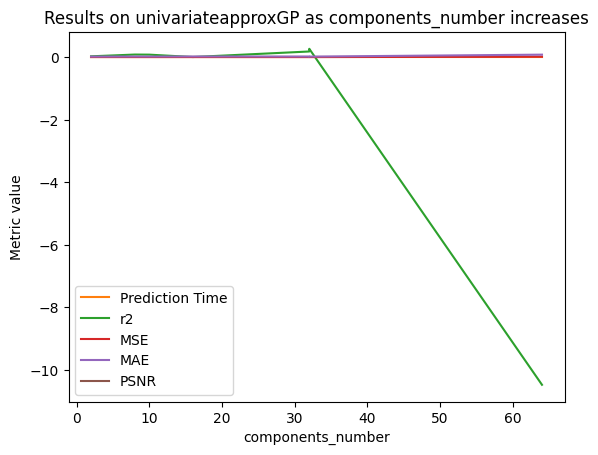

,Model Description,Prediction Time,r2,MSE,MAE,PSNR,components_number
20,univariate_approxGP_2fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,6.557993e-09,0.025679,0.001211,0.016694,NaN,2
19,univariate_approxGP_4fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,4.682481e-09,0.044151,0.001188,0.017479,NaN,4
18,univariate_approxGP_8fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,4.214068e-09,0.081672,0.001142,0.019079,NaN,8
14,univariate_approxGP_10fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.915616e-07,0.078893,0.001145,0.018066,NaN,10
17,univariate_approxGP_16fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,5.935095e-09,0.002538,0.001240,0.020174,NaN,16
15,univariate_approxGP_32fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,6.947346e-07,0.179738,0.001020,0.018800,NaN,32
21,univariate_approxGP_32fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.063439e-08,0.266360,0.000912,0.016319,NaN,32
16,univariate_approxGP_64fourier-components_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.745479e-06,-10.478075,0.014271,0.078882,NaN,64


In [21]:
"""Study on the number of components approximate GP (needs to consider the records with "consider_ws")"""

metrics = load_metrics_by_model("approxGP", set_type="test", experiments=["OLD"])

metrics = extract_parameter(metrics, parameter_name="components_number", parameter_type=int, regex=r"approxGP_(\d+)fourier")
plot_metrics_per_parameter(metrics, "components_number")
metrics

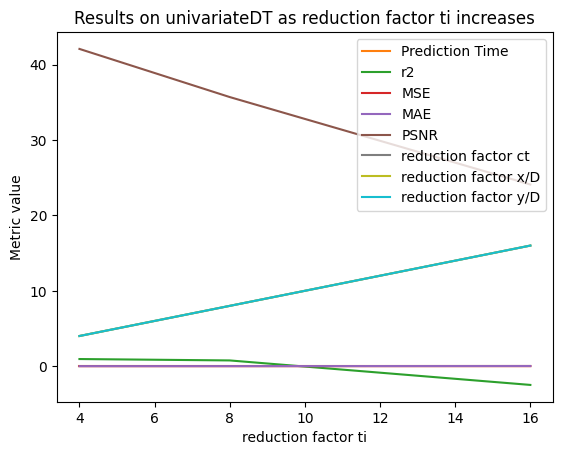

,Model Description,Prediction Time,r2,MSE,MAE,PSNR,reduction factor ti,reduction factor ct,reduction factor x/D,reduction factor y/D
2,univariate_DT_max-depthNone_training_factors=ti4-ct4-x/D4-y/D4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,6.157988e-08,0.944565,0.000062,0.002889,42.095377,4,4,4,4
3,univariate_DT_max-depthNone_training_factors=ti8-ct8-x/D8-y/D8_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,2.973334e-08,0.758781,0.000269,0.006318,35.706925,8,8,8,8
4,univariate_DT_max-depthNone_training_factors=ti16-ct16-x/D16-y/D16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,2.124950e-08,-2.490670,0.003889,0.022213,24.101299,16,16,16,16


In [22]:
"""Study on the training reduction factors (for Decision Tree)"""

metrics = load_metrics_by_model("DT", set_type="test", experiments=["interpolation_coords"])
regex = r"training_factors="
for var in ["ti", "ct", "x/D", "y/D"]:
    parameter_name = f"reduction factor {var}"
    regex = regex.replace("(", "").replace(")", "") + var + r"(\d+)"
    metrics = extract_parameter(metrics,
                                parameter_name=parameter_name,
                                parameter_type=int, regex=regex)
    regex += "-"
plot_metrics_per_parameter(metrics, "reduction factor ti")
metrics